In [1]:
from tensorflow.keras import datasets
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras import models, metrics, losses
import numpy as np
import tensorflow as tf


(x_train, y_train),(x_test, y_test) = datasets.fashion_mnist.load_data()

2024-02-29 05:17:11.463528: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-29 05:17:12.054672: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-02-29 05:17:12.054705: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-02-29 05:17:12.148780: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-29 05:17:13.848348: W tensorflow/stream_executor/platform/de

In [2]:
def preprocess(imgs):
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs,((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs
x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [3]:
# In this snippet, K.random_normal is a Keras function to generate random values following
# a Gaussian distribution. 'shape' indicates the shape of the output tensor. It defines how many
# random values we want to generate
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [4]:
# Defining the encoder
encoder_input = layers.Input(
    shape=(32, 32, 1), name="encoder_input"
)
x = layers.Conv2D(32,(3,3),strides=2,activation="relu",padding="same")(encoder_input)
x = layers.Conv2D(64, (3,3),strides=2,activation="relu",padding="same")(x)
x = layers.Conv2D(128,(3,3),strides=2,activation="relu",padding="same")(x)

shape_before_flattening = K.int_shape(x)[1:]
x = layers.Flatten()(x)
z_mean = layers.Dense(2,name="z_mean")(x)
z_log_var = layers.Dense(2,name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")

2024-02-29 05:17:17.781173: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-02-29 05:17:17.781825: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-02-29 05:17:17.781858: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (b6aaffa9ad21): /proc/driver/nvidia/version does not exist
2024-02-29 05:17:17.782685: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# Here we want to define the decoder
decoder_input = layers.Input(shape=(2,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3,3),strides=2,activation="relu",padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3,3),strides=2,activation="relu",padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3,3),strides=2,activation="relu",padding="same"
)(x)
decoder_output = layers.Conv2D(
    1,
    (3,3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)
decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        147584    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 32)       18464 

In [6]:
# Building the VAE as a subclass of the Keras Model class
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")
        
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker
        ]
    
    def call(self, inputs):
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(500 * losses.binary_crossentropy(data, reconstruction, axis=(1,2,3)))
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis = 1,
                )
            )
            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {m.name: m.result() for m in self.metrics}

In [7]:
# Benchmark to beat: total_loss: 131.5970 - reconstruction_loss: 126.3598 - kl_loss: 5.2372, achieved with Adam
# Using adam optimizer, with epochs 7, batch_size 200 we got total_loss: 129.8120 - reconstruction_loss: 124.4130 - kl_loss: 5.399
from tensorflow.keras import optimizers

vae = VAE(encoder, decoder)
vae.compile(optimizer="adam")
vae.fit(
    x_train,
    epochs=7,
    batch_size=200,
    shuffle=True,
    validation_data=(x_test, x_test),
)

Epoch 1/7
300/300 [==============================] - 86s 283ms/step - total_loss: 166.1740 - reconstruction_loss: 161.8909 - kl_loss: 4.2830 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 2/7
300/300 [==============================] - 84s 282ms/step - total_loss: 136.3753 - reconstruction_loss: 131.4262 - kl_loss: 4.9491 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 3/7
300/300 [==============================] - 94s 312ms/step - total_loss: 134.2885 - reconstruction_loss: 129.2384 - kl_loss: 5.0502 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 4/7
300/300 [==============================] - 70s 234ms/step - total_loss: 133.2510 - reconstruction_loss: 128.1335 - kl_loss: 5.1176 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 5/7
300/300 [==============================] - 78s 259ms/s

In [11]:
examples_images = x_test[:500]
example_labels = y_test[:500]

In [16]:
z_mean, z_log_var, reconstructions = vae.predict(examples_images)
print(reconstructions[:2])

16/16 [==============================] - 0s 13ms/step
[[[[6.97562896e-08]
   [1.51981971e-09]
   [2.24107266e-09]
   ...
   [1.79084325e-09]
   [1.09789315e-08]
   [3.66823338e-06]]

  [[1.91037117e-10]
   [1.66661596e-12]
   [9.79284622e-12]
   ...
   [9.96902783e-10]
   [2.24511143e-09]
   [5.05897162e-07]]

  [[6.82658305e-11]
   [4.03628303e-12]
   [2.21844598e-10]
   ...
   [3.86310694e-06]
   [2.65467747e-07]
   [3.36546827e-06]]

  ...

  [[2.81765522e-09]
   [9.26548394e-10]
   [1.21932944e-08]
   ...
   [1.70302741e-08]
   [2.33625252e-09]
   [1.41681824e-07]]

  [[4.72888608e-08]
   [7.56023866e-09]
   [7.61578534e-09]
   ...
   [1.63513239e-08]
   [9.19409826e-10]
   [7.87773828e-08]]

  [[2.13174080e-05]
   [2.22723884e-06]
   [1.79155677e-06]
   ...
   [7.16860370e-07]
   [2.94015337e-07]
   [2.80355052e-05]]]


 [[[8.34505918e-05]
   [6.37372750e-06]
   [6.69438941e-06]
   ...
   [5.89558056e-07]
   [1.45066360e-06]
   [3.31423726e-05]]

  [[2.86717818e-06]
   [3.03778222

16/16 [==============================] - 0s 4ms/step


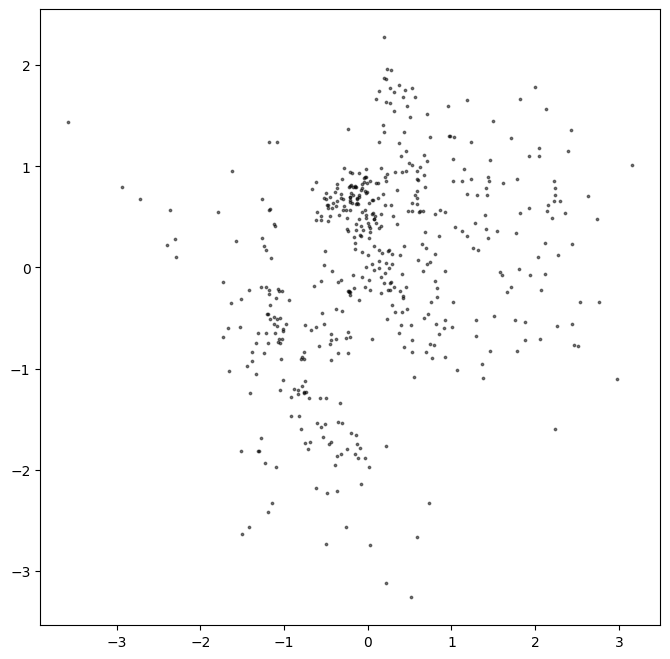

In [20]:
z_mean, z_var, z = encoder.predict(examples_images)

import matplotlib.pyplot as plt

figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()